UIDAI Aadhaar Enrolment Data Analysis

This notebook is part of the UIDAI Data Hackathon 2026.

Objective:

Analyse Aadhaar enrolment trends across age groups

Identify operational and policy-relevant insights at state, district, and pincode levels

Dataset source: UIDAI Aadhaar Enrolment dataset (Government of India)

### Reading data from the raw csv files given to us

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
# plotting defaults (you can tweak)
plt.rcParams["figure.dpi"] = 100
base_dir = Path.cwd().parents[0]
raw_dir = base_dir / "data" / "raw" #keep the orignal csv files in the {base_dir}/data/raw
clean_dir = base_dir / "data" / "cleaned" #orignal might be having some duplicated data or typing errors we will fix them in new csvs and put new csvs in (base_dir}/data/cleaned
csv_files = [
    "api_data_aadhar_enrolment_0_500000.csv",
    "api_data_aadhar_enrolment_500000_1000000.csv",
    "api_data_aadhar_enrolment_1000000_1006029.csv"
]
df1 = pd.read_csv(raw_dir / csv_files[0])
df2 = pd.read_csv(raw_dir / csv_files[1])
df3 = pd.read_csv(raw_dir / csv_files[2])


In [2]:
def filter_by_level(df, level, state=None, district=None, pincode=None):
    level = level.strip().lower()

    if level == "national":
        return df

    elif level == "state":
        if not state:
            raise ValueError("State required")

        return df[
            df["state"].astype(str).str.strip().str.lower()
            == state.strip().lower()
        ]

    elif level == "district":
        if not state or not district:
            raise ValueError("State and District required")

        return df[
            (df["state"].astype(str).str.strip().str.lower()
             == state.strip().lower())
            &
            (df["district"].astype(str).str.strip().str.lower()
             .str.contains(district.strip().lower(), na=False))
        ]

    elif level == "pincode":
        if not pincode:
            raise ValueError("Pincode required")

        return df[
            df["pincode"].astype(str).str.strip()
            == str(pincode).strip()
        ]

    else:
        raise ValueError("Invalid level")


In [3]:
age_cols = ["age_0_5", "age_5_17", "age_18_greater"]

In [4]:
df_original = pd.concat([df1, df2, df3], ignore_index=True)
df_original

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,02-03-2025,Meghalaya,East Khasi Hills,793121,11,61,37
1,09-03-2025,Karnataka,Bengaluru Urban,560043,14,33,39
2,09-03-2025,Uttar Pradesh,Kanpur Nagar,208001,29,82,12
3,09-03-2025,Uttar Pradesh,Aligarh,202133,62,29,15
4,09-03-2025,Karnataka,Bengaluru Urban,560016,14,16,21
...,...,...,...,...,...,...,...
1006024,31-12-2025,West Bengal,West Midnapore,721149,2,0,0
1006025,31-12-2025,West Bengal,West Midnapore,721150,2,2,0
1006026,31-12-2025,West Bengal,West Midnapore,721305,0,1,0
1006027,31-12-2025,West Bengal,West Midnapore,721504,1,0,0


## Did some analysis before data cleaning 

In [5]:
print(df_original.info())
print("\n\n")
print(df_original.describe())
print("\n\n")
print(df_original.columns)
print("\n\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006029 entries, 0 to 1006028
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   date            1006029 non-null  object
 1   state           1006029 non-null  object
 2   district        1006029 non-null  object
 3   pincode         1006029 non-null  int64 
 4   age_0_5         1006029 non-null  int64 
 5   age_5_17        1006029 non-null  int64 
 6   age_18_greater  1006029 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 53.7+ MB
None



            pincode       age_0_5      age_5_17  age_18_greater
count  1.006029e+06  1.006029e+06  1.006029e+06    1.006029e+06
mean   5.186415e+05  3.525709e+00  1.710074e+00    1.673441e-01
std    2.056360e+05  1.753851e+01  1.436963e+01    3.220525e+00
min    1.000000e+05  0.000000e+00  0.000000e+00    0.000000e+00
25%    3.636410e+05  1.000000e+00  0.000000e+00    0.000000e+00
50%    5.174170e+05  2.000000e+

In [6]:
print(df_original.isnull().sum(),"\n\n")
print((df_original == "").sum(),"\n\n")
print(df_original.dtypes,"\n\n")
print((df_original['date'] == pd.to_datetime(df_original['date'], errors='coerce')),"\n\n")
print(df_original['date'].isnull().sum(),"\n\n")
print((df_original[['age_0_5','age_5_17','age_18_greater']] < 0).sum(),"\n\n")
print(df_original.duplicated().sum(),"\n\n")

date              0
state             0
district          0
pincode           0
age_0_5           0
age_5_17          0
age_18_greater    0
dtype: int64 


date              0
state             0
district          0
pincode           0
age_0_5           0
age_5_17          0
age_18_greater    0
dtype: int64 


date              object
state             object
district          object
pincode            int64
age_0_5            int64
age_5_17           int64
age_18_greater     int64
dtype: object 


0           True
1           True
2           True
3           True
4           True
           ...  
1006024    False
1006025    False
1006026    False
1006027    False
1006028    False
Name: date, Length: 1006029, dtype: bool 


0 


age_0_5           0
age_5_17          0
age_18_greater    0
dtype: int64 


22957 




### Getting the state names in the raw file

In [7]:
sorted(df_original['state'].dropna().unique())

['100000',
 'Andaman & Nicobar Islands',
 'Andaman and Nicobar Islands',
 'Andhra Pradesh',
 'Arunachal Pradesh',
 'Assam',
 'Bihar',
 'Chandigarh',
 'Chhattisgarh',
 'Dadra & Nagar Haveli',
 'Dadra and Nagar Haveli',
 'Dadra and Nagar Haveli and Daman and Diu',
 'Daman & Diu',
 'Daman and Diu',
 'Delhi',
 'Goa',
 'Gujarat',
 'Haryana',
 'Himachal Pradesh',
 'Jammu & Kashmir',
 'Jammu And Kashmir',
 'Jammu and Kashmir',
 'Jharkhand',
 'Karnataka',
 'Kerala',
 'Ladakh',
 'Lakshadweep',
 'Madhya Pradesh',
 'Maharashtra',
 'Manipur',
 'Meghalaya',
 'Mizoram',
 'Nagaland',
 'ODISHA',
 'Odisha',
 'Orissa',
 'Pondicherry',
 'Puducherry',
 'Punjab',
 'Rajasthan',
 'Sikkim',
 'Tamil Nadu',
 'Telangana',
 'The Dadra And Nagar Haveli And Daman And Diu',
 'Tripura',
 'Uttar Pradesh',
 'Uttarakhand',
 'WEST BENGAL',
 'WESTBENGAL',
 'West  Bengal',
 'West Bangal',
 'West Bengal',
 'West bengal',
 'Westbengal',
 'andhra pradesh']

## Below is data cleaning, required only once

In [8]:
def initial_clean(df):
    # Parse date (dayfirst), coerce invalid -> NaT
    df["date"] = pd.to_datetime(df["date"], dayfirst=True, errors="coerce")

    # Ensure age columns numeric, fill missing with 0
    df[age_cols] = (
        df[age_cols]
        .apply(pd.to_numeric, errors="coerce")
        .fillna(0)
        .astype(int)
    )

    # Replace numeric-only state/district with NaN
    df["state"] = df["state"].where(~df["state"].astype(str).str.isdigit(), np.nan)
    df["district"] = df["district"].where(~df["district"].astype(str).str.isdigit(), np.nan)

    return df

df1 = initial_clean(df1)
df2 = initial_clean(df2)
df3 = initial_clean(df3)


### Correcting the State names

In [9]:
state_mapping = {
    # Dadra and Nagar Haveli and Daman and Diu 
    'Dadra & Nagar Haveli': 'Dadra and Nagar Haveli and Daman and Diu',
    'Dadra and Nagar Haveli': 'Dadra and Nagar Haveli and Daman and Diu',
    'Dadra and Nagar Haveli and Daman and Diu': 'Dadra and Nagar Haveli and Daman and Diu',
    'The Dadra And Nagar Haveli And Daman And Diu': 'Dadra and Nagar Haveli and Daman and Diu',
    'Daman & Diu': 'Dadra and Nagar Haveli and Daman and Diu',
    'Daman and Diu': 'Dadra and Nagar Haveli and Daman and Diu',

    
    # Andaman & Nicobar Islands
    'Andaman & Nicobar Islands': 'Andaman and Nicobar Islands',
    'Andaman and Nicobar Islands': 'Andaman and Nicobar Islands',
    
    # Jammu & Kashmir
    'Jammu & Kashmir': 'Jammu and Kashmir',
    'Jammu And Kashmir': 'Jammu and Kashmir',
    'Jammu and Kashmir': 'Jammu and Kashmir',
    
    # Odisha
    'ODISHA': 'Odisha',
    'Odisha': 'Odisha',
    'Orissa': 'Odisha',
    
    # Puducherry
    'Pondicherry': 'Puducherry',
    'Puducherry': 'Puducherry',
    
    # West Bengal
    'WEST BENGAL': 'West Bengal',
    'WESTBENGAL': 'West Bengal',
    'West  Bengal': 'West Bengal',
    'West Bangal': 'West Bengal',
    'West Bengal': 'West Bengal',
    'West bengal': 'West Bengal',
    'Westbengal': 'West Bengal',
    
    # Andhra Pradesh
    'andhra pradesh': 'Andhra Pradesh',
}

for df in [df1, df2, df3]:
    df.loc[:, "state"] = df["state"].replace(state_mapping)

### Correcting the district names

In [10]:
districts_by_state = (
    df_original
    .dropna(subset=["state", "district"])
    .groupby("state")["district"]
    .unique()
)
index = 0
for state, districts in districts_by_state.items():
    index += 1
    '''
    user_input = input("Press 'n' to stop, press Enter or type anything to continue: ")
    if user_input.lower() == 'n':
        print("Terminated by user.")
        break
'''
    # sort using lowercase + no-space key, but keep original display
    sorted_districts = sorted(
           districts,
           key=lambda x: x.replace(" ", "").lower()
    )

    print(f"\nState{index}. {state}\n")
    for d in sorted_districts:
        print(d)
    print("\n\n")


State1. 100000

100000




State2. Andaman & Nicobar Islands

Andamans
Nicobars
South Andaman




State3. Andaman and Nicobar Islands

Nicobar
North And Middle Andaman
South Andaman




State4. Andhra Pradesh

Adilabad
Alluri Sitharama Raju
Anakapalli
Anantapur
Ananthapur
Ananthapuramu
Annamayya
Bapatla
Chittoor
Cuddapah
Dr. B. R. Ambedkar Konaseema
East Godavari
Eluru
Guntur
Hyderabad
K.V.Rangareddy
K.v. Rangareddy
Kakinada
Karimnagar
Karim Nagar
Khammam
Krishna
Kurnool
Mahabub Nagar
Mahabubnagar
Mahbubnagar
Medak
N. T. R
Nalgonda
Nandyal
Nellore
Nizamabad
Palnadu
Parvathipuram Manyam
Prakasam
Rangareddi
Spsr Nellore
Srikakulam
Sri Potti Sriramulu Nellore
Sri Sathya Sai
Tirupati
Visakhapatanam
Visakhapatnam
Vizianagaram
Warangal
West Godavari
Y. S. R




State5. Arunachal Pradesh

Anjaw
Changlang
Dibang Valley
East Kameng
East Siang
Kamle
Kra Daadi
Kurung Kumey
Leparada
Lohit
Longding
Lower Dibang Valley
Lower Siang
Lower Subansiri
Namsai
Pakke Kessang
Papum Pare
Shi-yomi
Siang
Tawan

In [11]:
district_replace_map = {
    "Andaman and Nicobar Islands": {
        "Nicobars": "Nicobar",
        "Andamans": None
    },

    "Andhra Pradesh": {
        "chittoor": "Chittoor",
        "Anantapur": "Ananthapuramu",
        "Ananthapur": "Ananthapuramu",
        "Cuddapah": "Y. S. R",
        "K.V.Rangareddy": "Rangareddi",
        "K.v. Rangareddy": "Rangareddi",
        "rangareddi": "Rangareddi",
        "Spsr Nellore": "Sri Potti Sriramulu Nellore",
        "Visakhapatanam": "Visakhapatnam",
        "Karim Nagar": "Karimnagar",
        "Mahabub Nagar": "Mahabubnagar",
        "Mahbubnagar": "Mahabubnagar",
        "N. T. R": "NTR",
        "Hyderabad": None
    },

    "Arunachal Pradesh": {
        "Shi-yomi": "Shi Yomi"
    },

    "Assam": {
        "North Cachar Hills": "Dima Hasao",
        "Sibsagar": "Sivasagar",
        "Tamulpur District": "Tamulpur"
    },

    "Bihar": {
        "Aurangabad(bh)": "Aurangabad",
        "Aurangabad(BH)": "Aurangabad",
        "Bhabua": "Kaimur",
        "Monghyr": "Munger",
        "Purba Champaran": "East Champaran",
        "Purbi Champaran": "East Champaran",
        "Pashchim Champaran": "West Champaran",
        "Samstipur": "Samastipur",
        "Sheikpura": "Sheikhpura",
        "Purnea": "Purnia"
    },

    "Chandigarh": {
        "Rupnagar": None
    },

    "Chhattisgarh": {
        "Gaurela-pendra-marwahi": "Gaurela Pendra Marwahi",
        "Janjgir-champa": "Janjgir Champa",
        "Janjgir - Champa": "Janjgir Champa",
        "Mohla-Manpur-Ambagarh Chouki": "Mohalla-Manpur-Ambagarh Chowki",
        "Manendragarh–Chirmiri–Bharatpur": "Manendragarh Chirmiri Bharatpur",
        "Uttar Bastar Kanker": "Kanker",
        "Dakshin Bastar Dantewada": "Dantewada"
    },

    "Dadra and Nagar Haveli and Daman and Diu": {
        "Dadra & Nagar Haveli": "Dadra and Nagar Haveli",
        "Dadra And Nagar Haveli": "Dadra and Nagar Haveli"
    },

    "Delhi": {
        "North East": "North East Delhi",
        "North East   *": "North East Delhi"
    },

    "Gujarat": {
        "Ahmadabad": "Ahmedabad",
        "Banas Kantha": "Banaskantha",
        "Chhotaudepur": "Chhota Udaipur",
        "Dohad": "Dahod",
        "Panch Mahals": "Panchmahals",
        "Sabar Kantha": "Sabarkantha",
        "Surendra Nagar": "Surendranagar",
        "The Dangs": "Dang"
    },

    "Haryana": {
        "Jhajjar *": "Jhajjar",
        "Yamuna Nagar": "Yamunanagar",
        "Mewat": "Nuh"
    },

    "Himachal Pradesh": {
        "Lahul & Spiti": "Lahaul and Spiti",
        "Lahul and Spiti": "Lahaul and Spiti"
    },

    "Jammu and Kashmir": {
        "Bandipore": "Bandipora",
        "Baramula": "Baramulla",
        "Punch": "Poonch",
        "punch": "Poonch",
        "Rajauri": "Rajouri",
        "Shupiyan": "Shopian",
        "Leh (ladakh)": "Leh"
    },

    "Jharkhand": {
        "Bokaro *": "Bokaro",
        "Garhwa *": "Garhwa",
        "East Singhbum": "East Singhbhum",
        "Hazaribag": "Hazaribagh",
        "Kodarma": "Koderma",
        "Pakaur": "Pakur",
        "Palamau": "Palamu",
        "Pashchimi Singhbhum": "West Singhbhum",
        "Purbi Singhbhum": "East Singhbhum",
        "Seraikela-kharsawan": "Seraikela-Kharsawan"
    },

    "Karnataka": {
        "Bagalkot *": "Bagalkot",
        "Gadag *": "Gadag",
        "Udupi *": "Udupi",
        "Chamarajanagar *": "Chamarajanagar",
        "Chamrajnagar": "Chamarajanagar",
        "Chamrajanagar": "Chamarajanagar",
        "Belgaum": "Belagavi",
        "Bellary": "Ballari",
        "Gulbarga": "Kalaburagi",
        "Bijapur": "Vijayapura",
        "Bijapur(KAR)": "Vijayapura",
        "Hasan": "Hassan",
        "Davangere": "Davanagere",
        "Shimoga": "Shivamogga",
        "Tumkur": "Tumakuru",
        "Mysore": "Mysuru",
        "yadgir": "Yadgir"
    },

    "Kerala": {
        "Kasargod": "Kasaragod"
    },

    "Ladakh": {},

    "Lakshadweep": {},

    "Madhya Pradesh": {
        "Ashok Nagar": "Ashoknagar",
        "Harda *": "Harda",
        "East Nimar": "Khandwa",
        "West Nimar": "Khargone",
        "Hoshangabad": "Narmadapuram",
        "Narsimhapur": "Narsinghpur"
    },
    
    "Maharashtra": {
        "Ahmadnagar": "Ahmednagar",
        "Ahmed Nagar": "Ahmednagar",
        "Bid": "Beed",
        "Gondiya": "Gondia",
        "Gondiya *": "Gondia",
        "Hingoli *": "Hingoli",
        "Nandurbar *": "Nandurbar",
        "Washim *": "Washim",
        "Raigarh": None,
        "Raigarh(MH)": None,
        "Mumbai( Sub Urban )": "Mumbai Suburban",
        "Chatrapati Sambhaji Nagar": "Chhatrapati Sambhajinagar",
        "Osmanabad": "Dharashiv"
    },
    
    "Manipur": {},
    
    "Meghalaya": {
        "Kamrup": None,
        "Jaintia Hills": None
    },
    
    "Mizoram": {
        "Mammit": "Mamit"
    },
    
    "Nagaland": {},
    
    "Odisha": {
        "ANGUL": "Angul",
        "Anugal": "Anugul",
        "ANUGUL": "Anugul",
        "Baleshwar": "Baleswar",
        "Baudh": "Boudh",
        "Jagatsinghapur": "Jagatsinghpur",
        "JAJPUR": "Jajpur",
        "jajpur": "Jajpur",
        "Kendrapara *": "Kendrapara",
        "Khorda": "Khordha",
        "Nabarangpur": "Nabarangapur",
        "NUAPADA": "Nuapada",
        "Sonapur": "Subarnapur",
        "Sundergarh": "Sundargarh"
    },
    
    "Puducherry": {
        "Pondicherry": "Puducherry"
    },
    
    "Punjab": {
        "Firozpur": "Ferozepur",
        "Muktsar": "Sri Muktsar Sahib",
        "Nawanshahr": "Shaheed Bhagat Singh Nagar",
        "S.A.S Nagar": "SAS Nagar (Mohali)",
        "S.A.S Nagar(Mohali)": "SAS Nagar (Mohali)"
    },
    
    "Rajasthan": {
        "Chittaurgarh": "Chittorgarh",
        "Deeg ": "Deeg",
        "Dhaulpur": "Dholpur",
        "Jalore": "Jalor",
        "Jhunjhunun": "Jhunjhunu"
    },
    
    "Sikkim": {
        "East": "East Sikkim",
        "North": "North Sikkim",
        "South": "South Sikkim",
        "West": "West Sikkim"
    },
    
    "Tamil Nadu": {
        "Kancheepuram": "Kanchipuram",
        "Namakkal   *": "Namakkal",
        "The Nilgiris": "Nilgiris",
        "Tiruvallur": "Thiruvallur",
        "Tuticorin": "Thoothukkudi",
        "Viluppuram": "Villupuram"
    },
    
    "Telangana": {
        "Jangoan": "Jangaon",
        "K.v. Rangareddy": "Ranga Reddy",
        "Medchal-malkajgiri": "Medchal Malkajgiri",
        "Medchal?malkajgiri": "Medchal Malkajgiri",
        "Medchal−malkajgiri": "Medchal Malkajgiri",
        "Rangareddy": "Ranga Reddy",
        "Warangal (urban)": "Warangal Urban",
        "Yadadri.": "Yadadri Bhuvanagiri"
    },
    
    "Tripura": {
        "Dhalai  *": "Dhalai"
    },

    "Uttar Pradesh": {
        "Bagpat": "Baghpat",
        "Bara Banki": "Barabanki",
        "Budaun": "Badaun",
        "Bulandshahr": "Bulandshahar",
        "Faizabad": "Ayodhya",
        "Jyotiba Phule Nagar": "Amroha",
        "Kushi Nagar": "Kushinagar",
        "Kushinagar *": "Kushinagar",
        "Mahrajganj": "Maharajganj",
        "Raebareli": "Rae Bareli",
        "Sant Ravidas Nagar Bhadohi": "Sant Ravidas Nagar",
        "Shrawasti": "Shravasti",
        "Siddharth Nagar": "Siddharthnagar"
    },
    
    "Uttarakhand": {
        "Hardwar": "Haridwar",
        "Garhwal": None
    },
    
    "West Bengal": {
        "24 Paraganas North": "North 24 Parganas",
        "24 Paraganas South": "South 24 Parganas",
        "Barddhaman": "Bardhaman",
        "Burdwan": "Bardhaman",
        "Coochbehar": "Cooch Behar",
        "Darjiling": "Darjeeling",
        "East Midnapore": "Purba Medinipur",
        "East Midnapur": "Purba Medinipur",
        "Haora": "Howrah",
        "Hawrah": "Howrah",
        "Hooghiy": "Hooghly",
        "HOOGHLY": "Hooghly",
        "hooghly": "Hooghly",
        "HOWRAH": "Howrah",
        "Hugli": "Hooghly",
        "Koch Bihar": "Cooch Behar",
        "KOLKATA": "Kolkata",
        "MALDA": "Malda",
        "Maldah": "Malda",
        "Medinipur": None,
        "Medinipur West": "Paschim Medinipur",
        "North Twenty Four Parganas": "North 24 Parganas",
        "Puruliya": "Purulia",
        "South 24 Pargana": "South 24 Parganas",
        "South 24 parganas": "South 24 Parganas",
        "South Twenty Four Parganas": "South 24 Parganas",
        "West Medinipur": "Paschim Medinipur",
        "West Midnapore": "Paschim Medinipur"
    }
}


def replace_districts_statewise(df, state_col="state", district_col="district"):
    # Only operate when state is present
    for state, repl in district_replace_map.items():
        mask = df[state_col] == state
        if mask.any():
            df.loc[mask, district_col] = df.loc[mask, district_col].replace(repl)
    return df





In [12]:
df1 = replace_districts_statewise(df1)
df2 = replace_districts_statewise(df2)
df3 = replace_districts_statewise(df3)

## Aggregating the rows which are for same date, state, district and state

In [13]:
def aggregate_df(df):
    return df.groupby(
        ["date", "state", "district", "pincode"],
        dropna=False,
        as_index=False
    )[
        ["age_0_5", "age_5_17", "age_18_greater"]
    ].sum()

df1 = aggregate_df(df1)
df2 = aggregate_df(df2)
df3 = aggregate_df(df3)

In [14]:
for df in (df1, df2, df3):
    # date is already datetime; derive month/weekday helpers for ordering & display
    df["total_enrolments"] = df[age_cols].sum(axis=1)
    df["month"] = df["date"].dt.month_name()         # string like 'March'
    df["month_order"] = df["date"].dt.month          # integer 1..12
    df["weekday"] = df["date"].dt.day_name()         # string like 'Monday'
    df["weekday_order"] = df["date"].dt.weekday      # integer 0..6 (Mon=0
    

In [15]:
df_original = pd.concat([df1, df2, df3], ignore_index=True)
print("df_original rows:", len(df_original))
print("Sample columns:", df_original.columns.tolist())
print(f"The dataset contains {len(df_original['state'].unique())} states")

df_original rows: 946628
Sample columns: ['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17', 'age_18_greater', 'total_enrolments', 'month', 'month_order', 'weekday', 'weekday_order']
The dataset contains 37 states


### Puting the data in new csv files 

In [16]:
#run this only once on your system
clean_dir.mkdir(parents=True, exist_ok=True)
df1.to_csv(clean_dir/csv_files[0], index=False)
df2.to_csv(clean_dir/csv_files[1], index=False)
df3.to_csv(clean_dir/csv_files[2], index=False)

### Loading the cleaned data

In [17]:
df_clean = pd.concat(
    (pd.read_csv(clean_dir / f) for f in csv_files),
    ignore_index=True
)
df_clean

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,total_enrolments,month,month_order,weekday,weekday_order
0,2025-03-02,Meghalaya,East Khasi Hills,793121,11,61,37,109,March,3,Sunday,6
1,2025-03-09,Bihar,Bhagalpur,812005,13,40,18,71,March,3,Sunday,6
2,2025-03-09,Bihar,East Champaran,845304,18,72,12,102,March,3,Sunday,6
3,2025-03-09,Bihar,East Champaran,845418,30,48,10,88,March,3,Sunday,6
4,2025-03-09,Bihar,Madhubani,847108,18,120,22,160,March,3,Sunday,6
...,...,...,...,...,...,...,...,...,...,...,...,...
946623,2025-12-31,West Bengal,Uttar Dinajpur,733156,8,9,0,17,December,12,Wednesday,2
946624,2025-12-31,West Bengal,Uttar Dinajpur,733201,33,26,1,60,December,12,Wednesday,2
946625,2025-12-31,West Bengal,Uttar Dinajpur,733207,22,23,0,45,December,12,Wednesday,2
946626,2025-12-31,West Bengal,Uttar Dinajpur,733212,2,1,0,3,December,12,Wednesday,2


### Month-wise Aadhar Enrolment Data

In [18]:
def months_template_df(value_col="total_enrolments"):
    months = pd.DataFrame({
        "month_order": list(range(1,13))
    })
    months["month"] = months["month_order"].apply(lambda m: pd.Timestamp(2025, m, 1).month_name())
    months[value_col] = 0
    return months

In [19]:
def monthly_analysis():
    level = input("Choose level (national/state/district/pincode): ").strip().lower()

    state = district = pincode = None

    if level == "state":
        state = input("Enter State: ")

    elif level == "district":
        state = input("Enter State (required): ")
        district = input("Enter District: ")

    elif level == "pincode":
        pincode = input("Enter Pincode: ")

    df_scope = filter_by_level(df_clean, level, state, district, pincode)

    if df_scope.empty:
        print("No data found.")
        return

    df_scope = df_scope.copy()
    df_scope["date"] = pd.to_datetime(df_scope["date"], errors="coerce")
    df_scope["month"] = df_scope["date"].dt.strftime("%b")
    df_scope["month_order"] = df_scope["date"].dt.month

    agg = (
        df_scope
        .groupby(["month_order", "month"], as_index=False)["total_enrolments"]
        .sum()
        .sort_values("month_order")
    )

    plt.figure(figsize=(9, 4))
    plt.bar(agg["month"], agg["total_enrolments"])
    plt.ylabel("Total Enrolments")
    plt.title("Monthly Enrolments")
    plt.tight_layout()
    plt.show()

In [20]:
'''
def monthly_analysis(df_scope, title="Monthly Enrolments (Jan→Dec)"):
    if df_scope.empty:
        safe_show_empty_plot("No data for given constraints.")
        return

    agg = df_scope.groupby(["month_order", "month"], as_index=False)["total_enrolments"].sum()
    template = months_template_df("total_enrolments")
    merged = template.merge(agg, on=["month_order", "month"], how="left", suffixes=("_tpl", ""))
    # where total_enrolments (from agg) is NaN, use 0
    merged["total_enrolments"] = merged["total_enrolments"].fillna(0).astype(int)
    merged = merged.sort_values("month_order")

    plt.figure(figsize=(10,5))
    plt.bar(merged["month"], merged["total_enrolments"], width=0.6)
    plt.xlabel("Month")
    plt.ylabel("Total Enrolments")
    plt.title(title)
    plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
'''

'\ndef monthly_analysis(df_scope, title="Monthly Enrolments (Jan→Dec)"):\n    if df_scope.empty:\n        safe_show_empty_plot("No data for given constraints.")\n        return\n\n    agg = df_scope.groupby(["month_order", "month"], as_index=False)["total_enrolments"].sum()\n    template = months_template_df("total_enrolments")\n    merged = template.merge(agg, on=["month_order", "month"], how="left", suffixes=("_tpl", ""))\n    # where total_enrolments (from agg) is NaN, use 0\n    merged["total_enrolments"] = merged["total_enrolments"].fillna(0).astype(int)\n    merged = merged.sort_values("month_order")\n\n    plt.figure(figsize=(10,5))\n    plt.bar(merged["month"], merged["total_enrolments"], width=0.6)\n    plt.xlabel("Month")\n    plt.ylabel("Total Enrolments")\n    plt.title(title)\n    plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter(\'{x:,.0f}\'))\n    plt.xticks(rotation=45)\n    plt.tight_layout()\n    plt.show()\n'

In [21]:
def daywise_analysis():
    level = input("Choose level (national/state/district/pincode): ").strip().lower()

    state = district = pincode = None

    if level == "state":
        state = input("Enter State: ")

    elif level == "district":
        state = input("Enter State (required): ")
        district = input("Enter District: ")

    elif level == "pincode":
        pincode = input("Enter Pincode: ")

    df_scope = filter_by_level(df_clean, level, state, district, pincode)

    if df_scope.empty:
        print("No data found.")
        return

    df_scope = df_scope.copy()
    df_scope["date"] = pd.to_datetime(df_scope["date"], errors="coerce")

    df_scope["weekday"] = df_scope["date"].dt.day_name()

    agg = (
        df_scope
        .groupby("weekday", as_index=False)["total_enrolments"]
        .sum()
    )

    order = [
        "Monday", "Tuesday", "Wednesday",
        "Thursday", "Friday", "Saturday", "Sunday"
    ]

    agg["weekday"] = pd.Categorical(agg["weekday"], categories=order, ordered=True)
    agg = agg.sort_values("weekday")

    plt.figure(figsize=(8, 4))
    plt.bar(agg["weekday"], agg["total_enrolments"])
    plt.ylabel("Total Enrolments")
    plt.title("Enrolments by Day of Week")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

In [22]:
'''
def daywise_analysis(df_scope, title_prefix="Daily Enrolments"):
    if df_scope.empty:
        safe_show_empty_plot("No data for given constraints.")
        return
    agg = df_scope.groupby("date", as_index=False)["total_enrolments"].sum().sort_values("date")
    agg["date_str"] = agg["date"].dt.strftime("%Y-%m-%d")

    plt.figure(figsize=(max(8, 0.35 * len(agg)), 4))
    plt.bar(agg["date_str"], agg["total_enrolments"], width=0.7)
    plt.xlabel("Date")
    plt.ylabel("Total Enrolments")
    plt.title(f"{title_prefix} (by date)")
    plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    '''

'\ndef daywise_analysis(df_scope, title_prefix="Daily Enrolments"):\n    if df_scope.empty:\n        safe_show_empty_plot("No data for given constraints.")\n        return\n    agg = df_scope.groupby("date", as_index=False)["total_enrolments"].sum().sort_values("date")\n    agg["date_str"] = agg["date"].dt.strftime("%Y-%m-%d")\n\n    plt.figure(figsize=(max(8, 0.35 * len(agg)), 4))\n    plt.bar(agg["date_str"], agg["total_enrolments"], width=0.7)\n    plt.xlabel("Date")\n    plt.ylabel("Total Enrolments")\n    plt.title(f"{title_prefix} (by date)")\n    plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter(\'{x:,.0f}\'))\n    plt.xticks(rotation=45)\n    plt.tight_layout()\n    plt.show()\n    '

In [47]:
def month_daywise_analysis():
    # --------------------------
    # Step 1: Ask month
    # --------------------------
    month_raw = input("Enter month number (1–12): ").strip()

    if not month_raw.isdigit():
        print("Invalid month.")
        return

    month_num = int(month_raw)
    if month_num < 1 or month_num > 12:
        print("Month must be between 1 and 12.")
        return

    # --------------------------
    # Step 2: Ask level
    # --------------------------
    level = input("Choose level (national/state/district/pincode): ").strip().lower()

    df_scope = df_clean.copy()
    title = f"Day-wise Enrolments (Mon–Sun) — Month {month_num}"

    # --------------------------
    # Step 3: Apply level filters
    # --------------------------
    if level == "state":
        state = input("Enter State: ").strip()
        df_scope = df_scope[
            df_scope["state"].str.lower() == state.lower()
        ]
        title += f" — {state}"

    elif level == "district":
        state = input("Enter State (required): ").strip()
        district = input("Enter District: ").strip()
        df_scope = df_scope[
            (df_scope["state"].str.lower() == state.lower()) &
            (df_scope["district"].str.lower() == district.lower())
        ]
        title += f" — {district}, {state}"

    elif level == "pincode":
        pin = input("Enter Pincode: ").strip()
        df_scope = df_scope[
            df_scope["pincode"].astype(str) == pin
        ]
        title += f" — Pincode {pin}"

    elif level != "national":
        print("Invalid level.")
        return

    if df_scope.empty:
        print("No data found.")
        return

    # --------------------------
    # Step 4: Month filter
    # --------------------------
    df_scope = df_scope.copy()
    df_scope["date"] = pd.to_datetime(df_scope["date"], errors="coerce")
    df_scope = df_scope[df_scope["date"].dt.month == month_num]

    if df_scope.empty:
        print("No data found for this month.")
        return

    # --------------------------
    # Step 5: Day-of-week aggregation
    # --------------------------
    df_scope["day_name"] = df_scope["date"].dt.day_name()
    df_scope["day_order"] = df_scope["date"].dt.weekday  # Monday=0

    agg = (
        df_scope
        .groupby(["day_order", "day_name"], as_index=False)["total_enrolments"]
        .sum()
    )

    # --------------------------
    # Step 6: Ensure Mon–Sun template
    # --------------------------
    days_template = pd.DataFrame({
        "day_order": list(range(7)),
        "day_name": [
            "Monday", "Tuesday", "Wednesday",
            "Thursday", "Friday", "Saturday", "Sunday"
        ]
    })

    merged = days_template.merge(
        agg,
        on=["day_order", "day_name"],
        how="left"
    )

    merged["total_enrolments"] = merged["total_enrolments"].fillna(0).astype(int)
    merged = merged.sort_values("day_order")

    # --------------------------
    # Step 7: Plot
    # --------------------------
    plt.figure(figsize=(10, 4))
    plt.bar(merged["day_name"], merged["total_enrolments"], width=0.6)
    plt.ylabel("Total Enrolments")
    plt.title(title)
    plt.xticks(rotation=30)
    plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
    plt.tight_layout()
    plt.show()


In [23]:
monthly_national = (
    df_clean.groupby(["month_order", "month"], as_index=False)["total_enrolments"]
      .sum()
      .sort_values("month_order")
)
monthly_national

,month_order,month,total_enrolments
0,3,March,16582
1,4,April,257438
2,5,May,183616
3,6,June,215734
4,7,July,616868
5,9,September,1475879
6,10,October,817920
7,11,November,1092007
8,12,December,759658


### A graph of Aadhar Enrolment across the Months from March to December

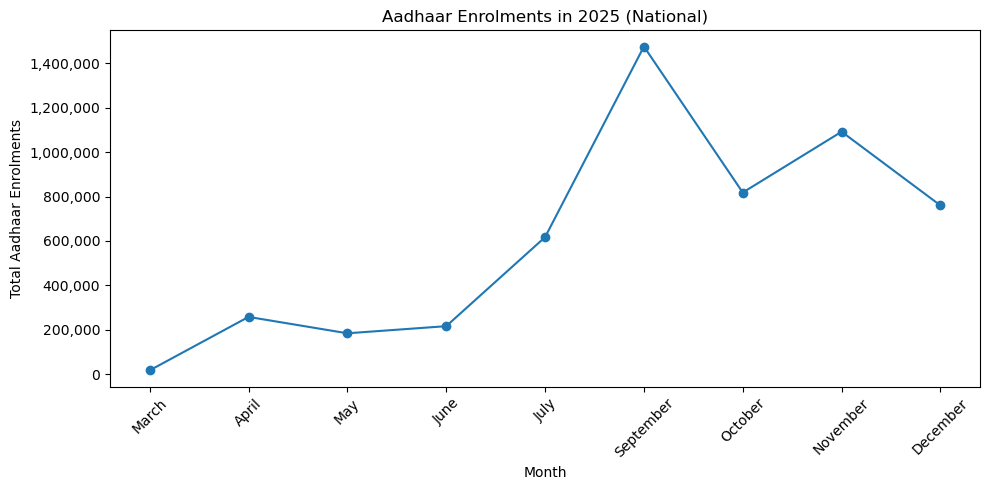

In [24]:
plt.figure(figsize=(10,5))
plt.plot(
    monthly_national["month"].astype(str),
    monthly_national["total_enrolments"],
    marker='o'
)
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Total Aadhaar Enrolments")
plt.title("Aadhaar Enrolments in 2025 (National)")

# Force exact numbers on y-axis
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.show()

### State-wise Aadhar Enrolment Data

In [25]:
# Group by state and sum age-group counts
state_age = (
    df_clean.groupby("state")[["age_0_5", "age_5_17", "age_18_greater", "total_enrolments"]]
      .sum()
      .sort_values("total_enrolments", ascending=False) 
)

state_age

,age_0_5,age_5_17,age_18_greater,total_enrolments
state,,,,
Uttar Pradesh,521045,479682,17902,1018629
Bihar,262875,334802,11908,609585
Madhya Pradesh,367990,116381,9599,493970
West Bengal,275420,91410,8510,375340
Maharashtra,278814,82116,8209,369139
Rajasthan,229780,113123,5555,348458
Gujarat,193031,71182,16336,280549
Assam,141235,66085,22877,230197
Karnataka,179262,33863,10110,223235


### Age-wise percentage of the 3 age groups across different states

In [26]:
state_age_ratios = state_age.div(state_age.sum(axis=1), axis=0)
state_age_ratios

,age_0_5,age_5_17,age_18_greater,total_enrolments
state,,,,
Uttar Pradesh,0.255758,0.235455,0.008787,0.5
Bihar,0.215618,0.274615,0.009767,0.5
Madhya Pradesh,0.372482,0.117802,0.009716,0.5
West Bengal,0.366894,0.121770,0.011336,0.5
Maharashtra,0.377654,0.111226,0.011119,0.5
Rajasthan,0.329710,0.162319,0.007971,0.5
Gujarat,0.344024,0.126862,0.029114,0.5
Assam,0.306770,0.143540,0.049690,0.5
Karnataka,0.401510,0.075846,0.022644,0.5


### A

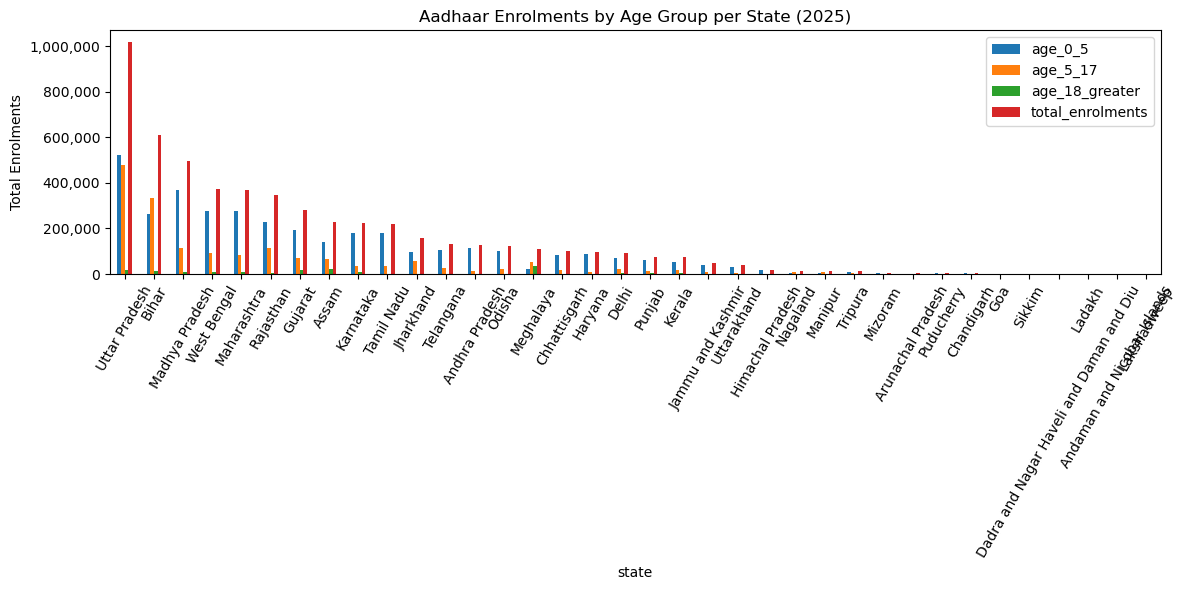

In [27]:
state_age.plot(
    kind="bar",
    figsize=(12,6)
)
plt.ylabel("Total Enrolments")
plt.title("Aadhaar Enrolments by Age Group per State (2025)")
plt.xticks(rotation=60)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()
#not looking good at all, also make the names short

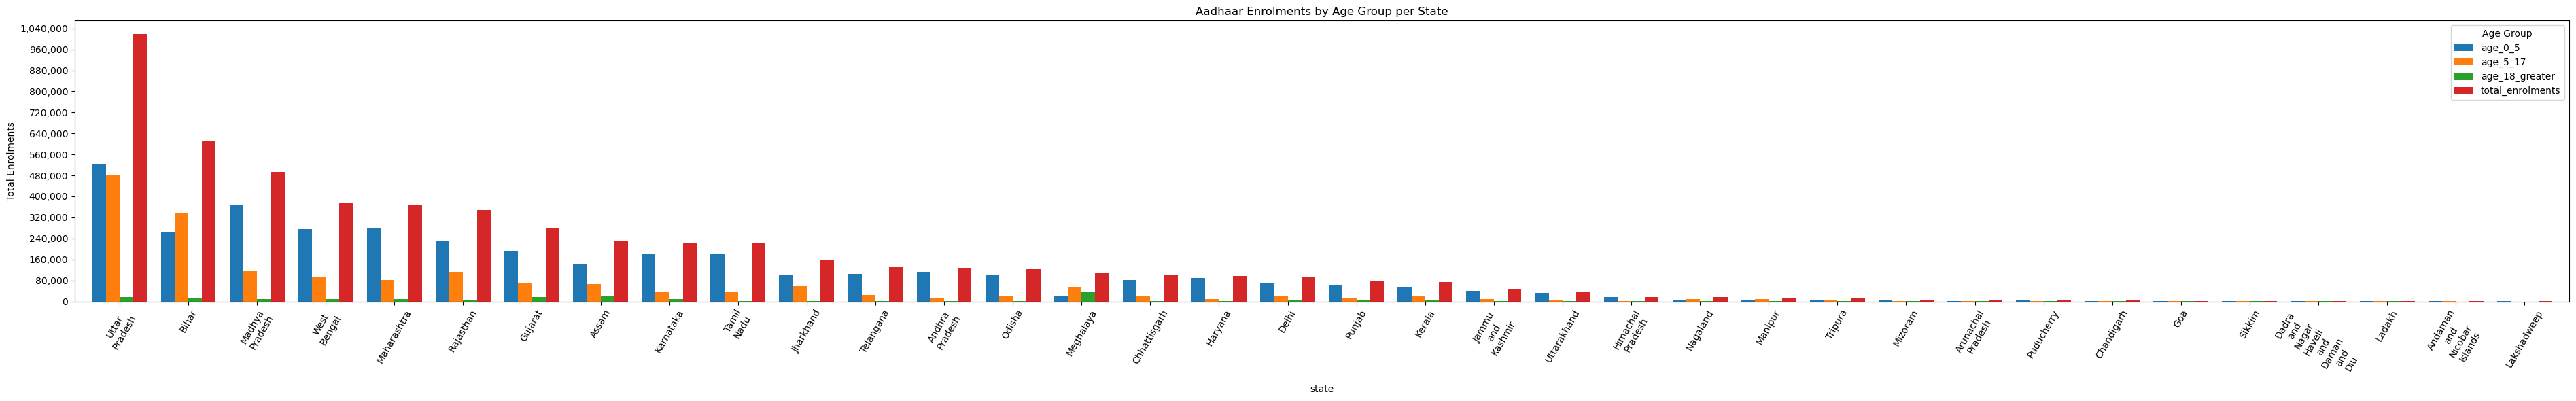

In [28]:
# shorten state names (clean and readable)
state_age_short = state_age.copy()
state_age_short.index = state_age_short.index.str.replace(" ", "\n")

state_age_short.plot(
    kind="bar",
    figsize=(38, 6),
    width=0.8
)

plt.ylabel("Total Enrolments")
plt.title("Aadhaar Enrolments by Age Group per State")
plt.xticks(rotation=60)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.legend(title="Age Group")
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(nbins=15))
plt.tight_layout()
plt.show()
#have to shorten the names
#arrange in order of highest enrollment(total) state first

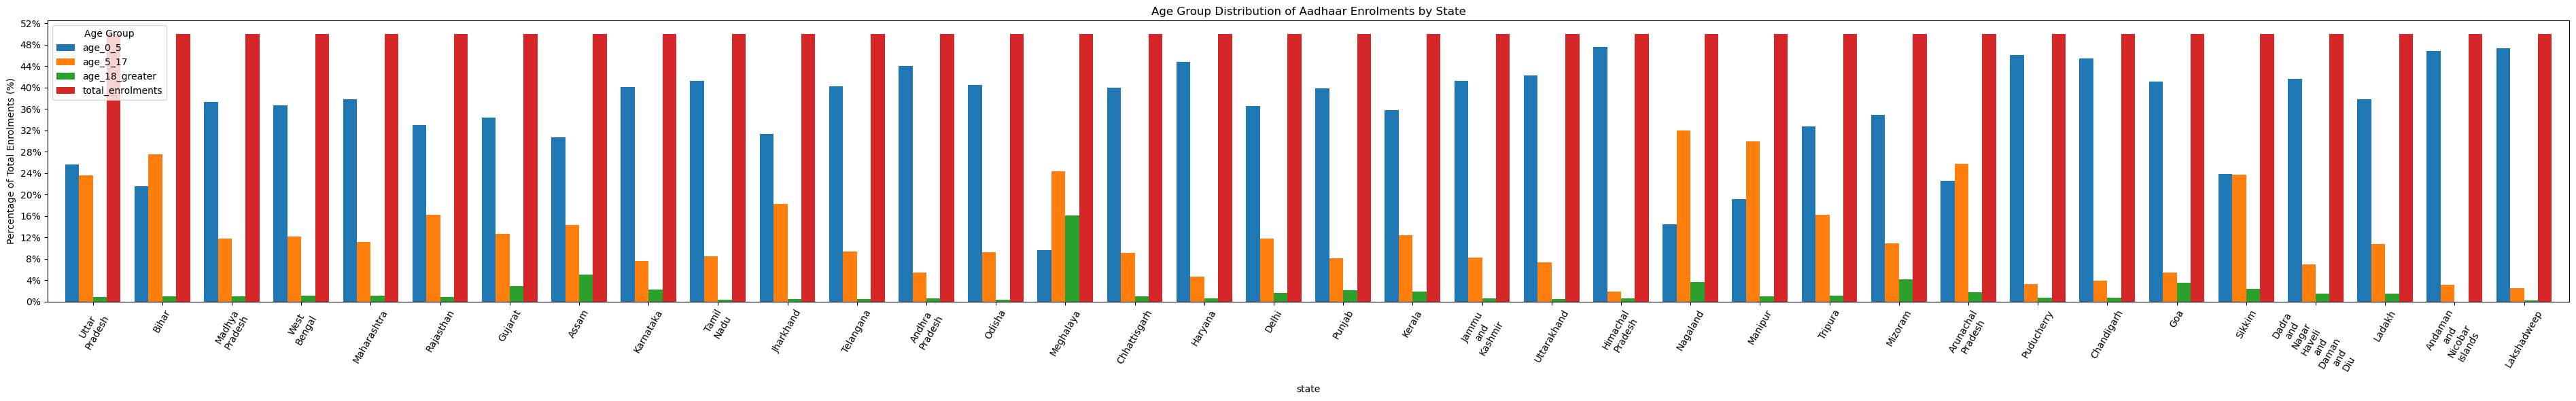

In [29]:
state_age_pct = state_age.div(state_age.sum(axis=1), axis=0) * 100

state_age_pct_short = state_age_pct.copy()
state_age_pct_short.index = state_age_pct_short.index.str.replace(" ", "\n")

state_age_pct_short.plot(
    kind="bar",
    figsize=(38, 6),
    width=0.8
)

plt.ylabel("Percentage of Total Enrolments (%)")
plt.title("Age Group Distribution of Aadhaar Enrolments by State")
plt.xticks(rotation=60)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.0f}%'))
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(nbins=15))
plt.legend(title="Age Group")
plt.tight_layout()
plt.show()
#have to shorten the names
#arrange in order of highest enrollment(total) state first

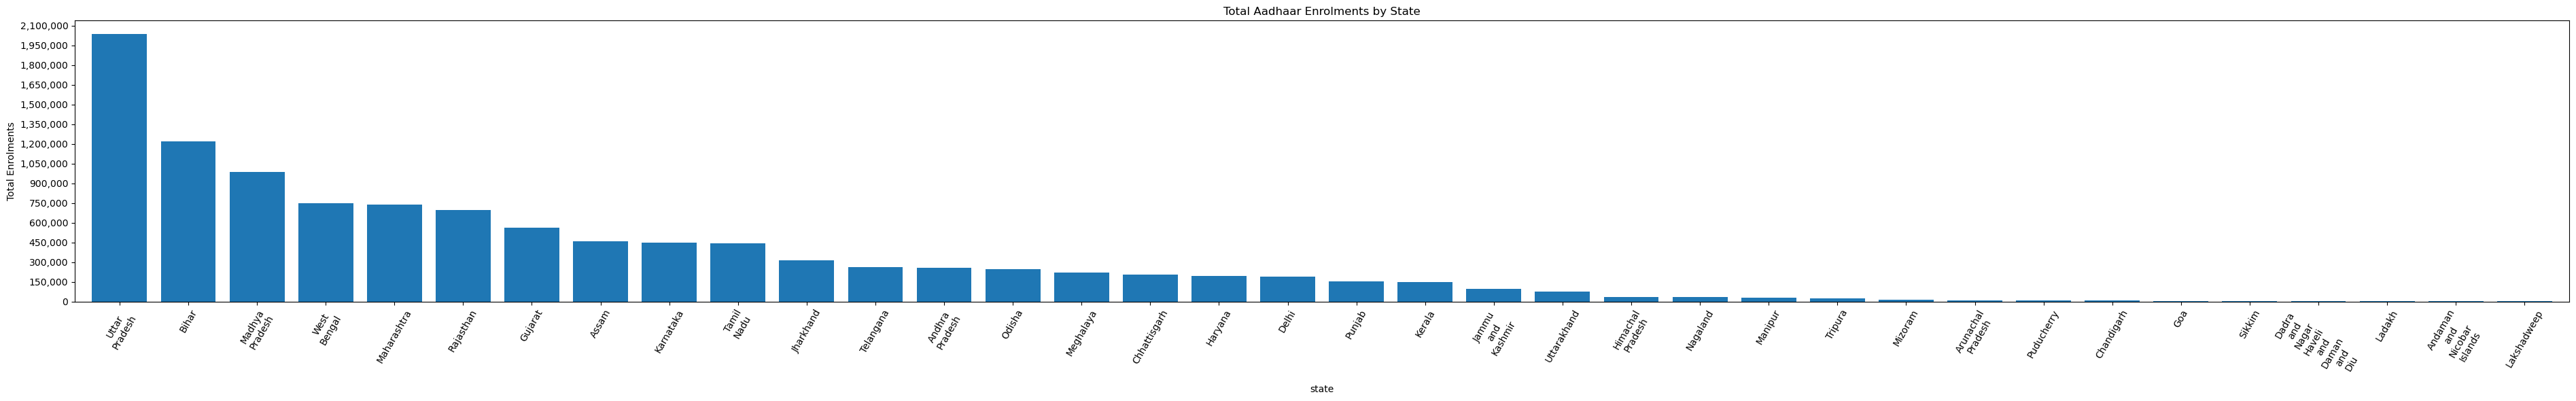

In [30]:
state_total = state_age.sum(axis=1)

state_total_short = state_total.copy()
state_total_short.index = state_total_short.index.str.replace(" ", "\n")

state_total_short.plot(
    kind="bar",
    figsize=(38, 6),
    width=0.8
)

plt.ylabel("Total Enrolments")
plt.title("Total Aadhaar Enrolments by State")
plt.xticks(rotation=60)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(nbins=15))
plt.tight_layout()
plt.show()
#arrange in order of highest enrollment(total) state first

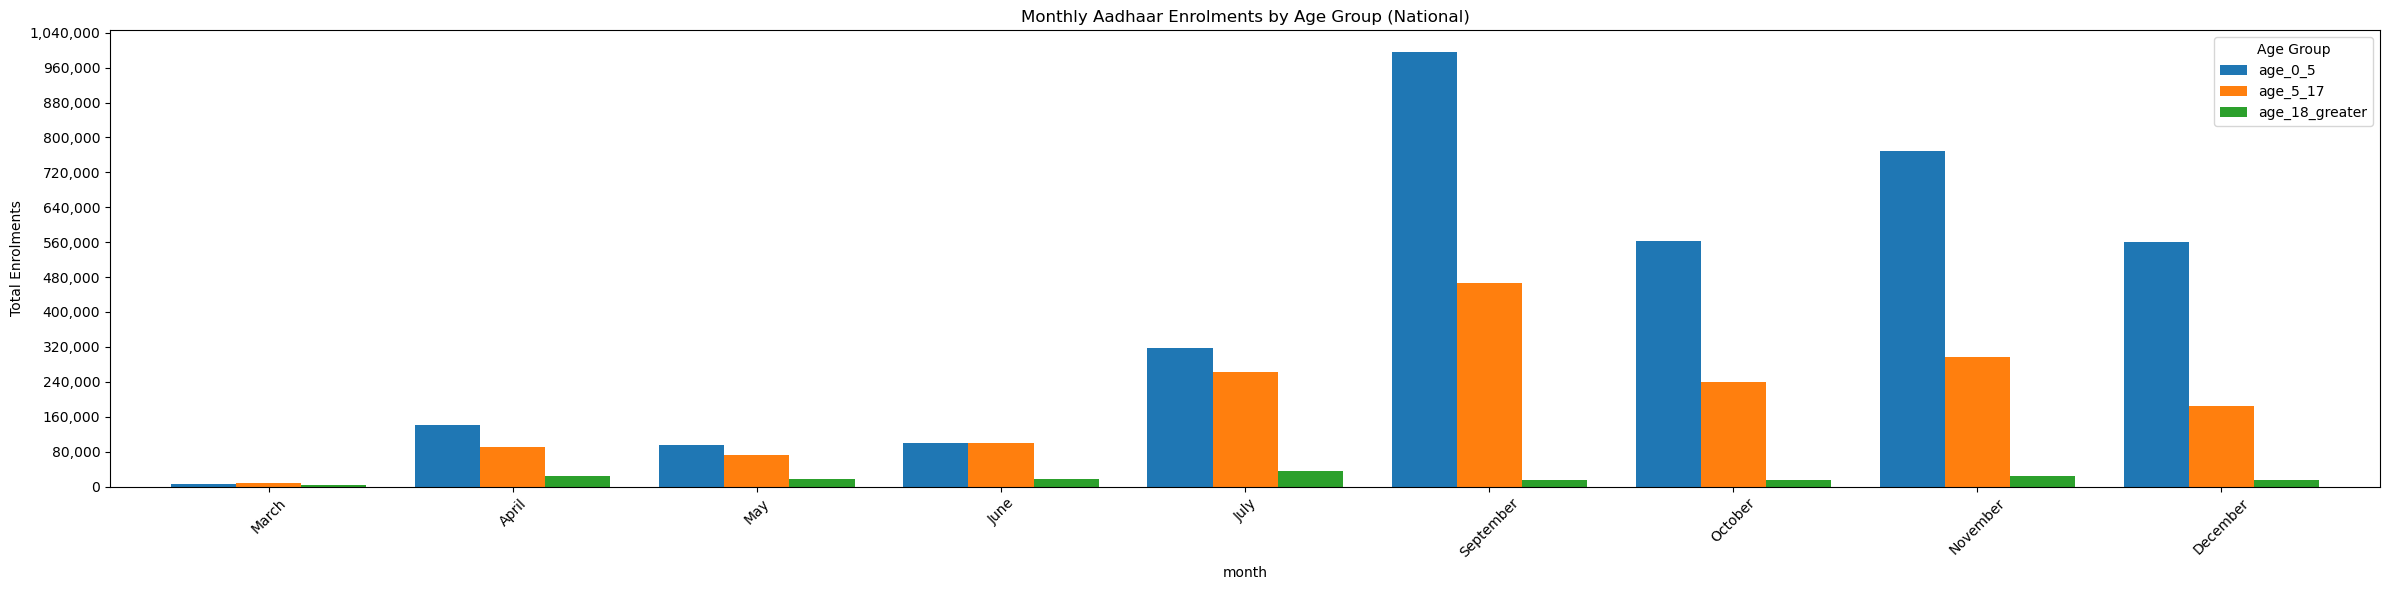

In [31]:
monthly_age = (
    df_clean
    .groupby(["month_order", "month"], as_index=False)[age_cols]
    .sum()
    .sort_values("month_order")
)
# set month names as index for plotting
monthly_age.index = monthly_age["month"].astype(str)
monthly_age[age_cols].plot(kind="bar", figsize=(24,6), width=0.8)


plt.ylabel("Total Enrolments")
plt.title("Monthly Aadhaar Enrolments by Age Group (National)")
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(nbins=15))
plt.legend(title="Age Group")
plt.tight_layout()
plt.show()
#arrange in order of highest enrollment(total) state first

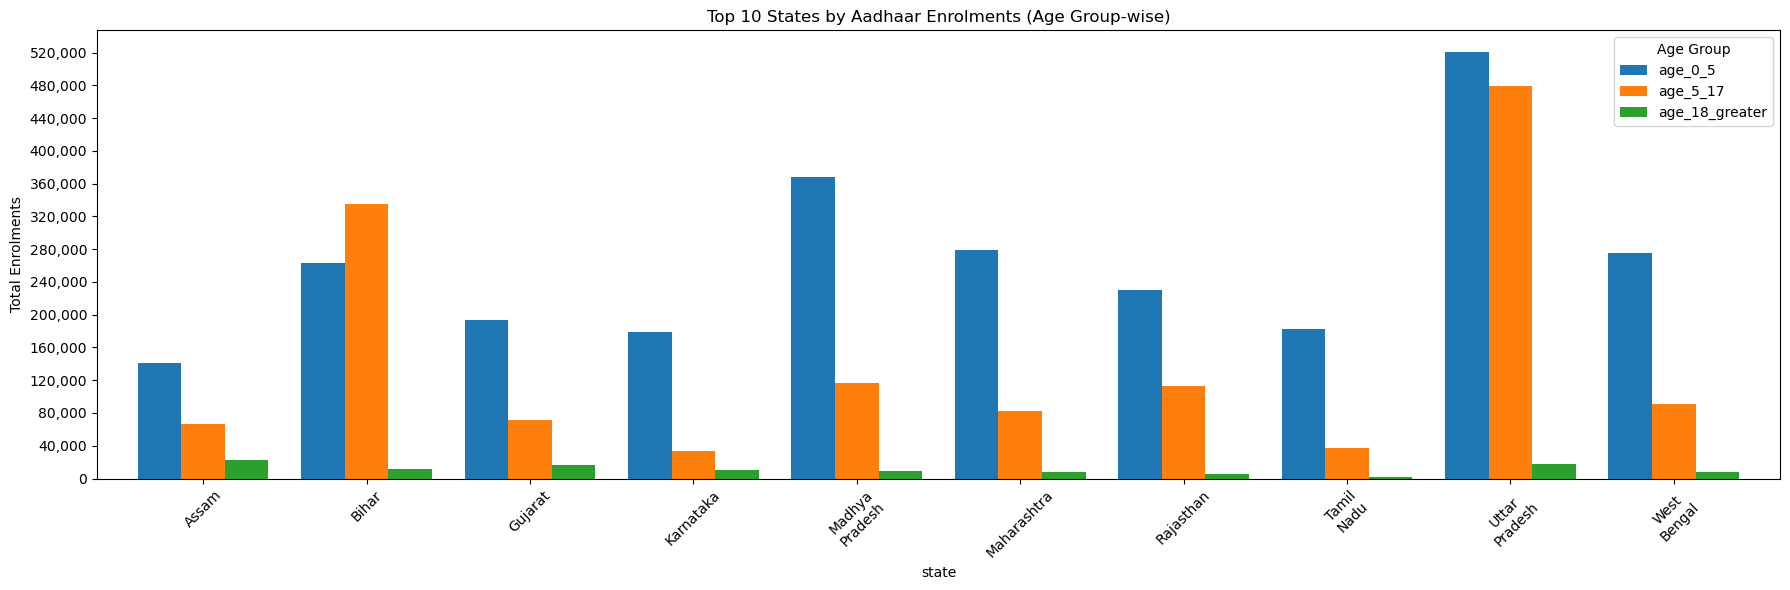

In [32]:
# top 10 states by total enrolments
top_states = (
    df_clean.groupby("state")["total_enrolments"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .index
)

top_state_age = (
    df_clean[df_clean["state"].isin(top_states)]
    .groupby("state")[age_cols]
    .sum()
)

# shorten state names
top_state_age_short = top_state_age.copy()
top_state_age_short.index = top_state_age_short.index.str.replace(" ", "\n")

top_state_age_short.plot(
    kind="bar",
    figsize=(18, 6),
    width=0.8
)

plt.ylabel("Total Enrolments")
plt.title("Top 10 States by Aadhaar Enrolments (Age Group-wise)")
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(nbins=15))
plt.legend(title="Age Group")
plt.tight_layout()
plt.show()
#arrange in order of highest enrollment(total) state first

In [33]:
_states = sorted(df_clean['state'].dropna().unique().tolist())
_districts = sorted(df_clean['district'].dropna().unique().tolist())
_pincodes = sorted(df_clean['pincode'].dropna().unique().astype(str).tolist())

def find_state(name):
    # case-insensitive find; returns canonical name or None
    name_lower = name.strip().lower()
    for s in _states:
        if s.lower() == name_lower:
            return s
    # try partial match
    for s in _states:
        if name_lower in s.lower():
            return s
    return None
    
def find_district(name):
    name_lower = name.strip().lower()
    for d in _districts:
        if d.lower() == name_lower:
            return d
    for d in _districts:
        if name_lower in d.lower():
            return d
    return None
    
def find_pincode(code):
    c = str(code).strip()
    return c if c in _pincodes else None

In [34]:
def age_wise_analysis():
    # ask for state until non-empty
    while True:
        state_name = input("Enter State name (case-insensitive) [required]: ").strip()
        if state_name != "":
            break
        print("State is required for this analysis. Please enter a state name.")

    # quick check: if state not found, say so and exit
    state_mask = df_clean["state"].astype(str).str.lower() == state_name.lower()
    if not state_mask.any():
        print("No data found for this state.")
        return

    # ask for district optionally
    district_name = input("Enter District name (leave blank for state-level): ").strip()

    if district_name == "":
        # STATE LEVEL
        state_df = df_clean[state_mask]

        # aggregate age groups
        age_df = state_df[age_cols].sum().reset_index()
        age_df.columns = ["Age Group", "Total Enrolments"]
        age_df["Age Group"] = age_df["Age Group"].replace({
            "age_0_5": "0–5",
            "age_5_17": "5–17",
            "age_18_greater": "18+"
        })

        # sort descending so highest is leftmost
        age_df = age_df.sort_values("Total Enrolments", ascending=False)

        # plot with custom order
        plt.figure(figsize=(8,5))
        plt.bar(age_df["Age Group"], age_df["Total Enrolments"], width=0.6)
        plt.xlabel("Age Group")
        plt.ylabel("Total Enrolments")
        plt.title(f"Aadhaar Enrolments by Age Group — {state_name}")
        plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
        plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(nbins=12))
        plt.tight_layout()
        plt.show()

    else:
        # DISTRICT LEVEL (respect state)
        district_mask = (df_clean["state"].astype(str).str.lower() == state_name.lower()) & \
                        (df_clean["district"].astype(str).str.lower() == district_name.lower())

        if not district_mask.any():
            print("No data found for this state/district.")
            return

        district_df = df_clean[district_mask]

        age_df = district_df[age_cols].sum().reset_index()
        age_df.columns = ["Age Group", "Total Enrolments"]
        age_df["Age Group"] = age_df["Age Group"].replace({
            "age_0_5": "0–5",
            "age_5_17": "5–17",
            "age_18_greater": "18+"
        })

        age_df = age_df.sort_values("Total Enrolments", ascending=False)

        plt.figure(figsize=(8,5))
        plt.bar(age_df["Age Group"], age_df["Total Enrolments"], width=0.6)
        plt.xlabel("Age Group")
        plt.ylabel("Total Enrolments")
        plt.title(f"Aadhaar Enrolments by Age Group — {district_name}, {state_name}")
        plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
        plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(nbins=12))
        plt.tight_layout()
        plt.show()

In [44]:
def enrolment_trend_analysis():
    raw = input("Enter District name OR Pincode: ").strip()

    # =========================
    # PINCODE LEVEL
    # =========================
    if raw.isdigit():
        df_scope = df_clean[
            df_clean["pincode"].astype(str).str.strip() == raw
        ]

        if df_scope.empty:
            print("No data found for this pincode.")
            return

        total = df_scope["total_enrolments"].sum()

        plt.figure(figsize=(6, 4))
        plt.bar(["Total Enrolments"], [total], width=0.5)
        plt.ylabel("Total Enrolments")
        plt.title(f"Aadhaar Enrolments — Pincode {raw}")
        plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
        plt.tight_layout()
        plt.show()
        return

    # =========================
    # DISTRICT LEVEL
    # =========================
    state = input("Enter State (required for district analysis): ").strip()

    df_scope = df_clean[
        (df_clean["state"].astype(str).str.strip().str.lower()
         == state.lower())
        &
        (df_clean["district"].astype(str).str.strip().str.lower()
         .str.contains(raw.lower(), na=False))
    ]

    if df_scope.empty:
        print("No data found for this state/district.")
        return

    total = df_scope["total_enrolments"].sum()

    plt.figure(figsize=(6, 4))
    plt.bar(["Total Enrolments"], [total], width=0.5)
    plt.ylabel("Total Enrolments")
    plt.title(f"Aadhaar Enrolments — {raw}, {state}")
    plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
    plt.tight_layout()
    plt.show()

In [36]:
'''
def enrolment_trend_analysis():
    raw = input("Enter District name OR Pincode: ").strip()

    # =========================
    # PINCODE LEVEL (numeric input)
    # =========================
    if raw.isdigit():
        pin_df = df_clean[df_clean["pincode"].astype(str) == raw]

        if pin_df.empty:
            print("No data found for this pincode.")
            return

        total = pin_df["total_enrolments"].sum()

        plt.figure(figsize=(6, 4))
        plt.bar(["Total Enrolments"], [total], width=0.5)

        plt.ylabel("Total Enrolments")
        plt.title(f"Aadhaar Enrolments — Pincode {raw}")
        plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
        plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(nbins=10))
        plt.tight_layout()
        plt.show()
        return

    # =========================
    # DISTRICT LEVEL (text input)
    # =========================
    else:
        # apply case-insensitive match on district
        district_mask = df_clean["district"].astype(str).str.lower() == raw.lower()
        if not district_mask.any():
            print("No data found for this district.")
            return

        district_df = df_clean[district_mask]

        # monthly aggregation + ensure Jan..Dec present
        agg = (
            district_df
            .groupby(["month_order", "month"], as_index=False)["total_enrolments"]
            .sum()
        )
        template = months_template_df("total_enrolments")
        merged = template.merge(agg, on=["month_order", "month"], how="left")
        merged["total_enrolments"] = merged["total_enrolments"].fillna(0).astype(int)
        merged = merged.sort_values("month_order")

        # plot Jan..Dec in proper order, showing zeros where missing
        plt.figure(figsize=(12, 4))
        plt.bar(merged["month"], merged["total_enrolments"], width=0.7)
        plt.ylabel("Total Enrolments")
        plt.title(f"Monthly Enrolments — {raw}")
        plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
        plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(nbins=8))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        '''

'\ndef enrolment_trend_analysis():\n    raw = input("Enter District name OR Pincode: ").strip()\n\n    # =========================\n    # PINCODE LEVEL (numeric input)\n    # =========================\n    if raw.isdigit():\n        pin_df = df_clean[df_clean["pincode"].astype(str) == raw]\n\n        if pin_df.empty:\n            print("No data found for this pincode.")\n            return\n\n        total = pin_df["total_enrolments"].sum()\n\n        plt.figure(figsize=(6, 4))\n        plt.bar(["Total Enrolments"], [total], width=0.5)\n\n        plt.ylabel("Total Enrolments")\n        plt.title(f"Aadhaar Enrolments — Pincode {raw}")\n        plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter(\'{x:,.0f}\'))\n        plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(nbins=10))\n        plt.tight_layout()\n        plt.show()\n        return\n\n    # =========================\n    # DISTRICT LEVEL (text input)\n    # =========================\n    else:\n        # apply case-i

Enter State name (case-insensitive) [required]:  maharashtra
Enter District name (leave blank for state-level):  


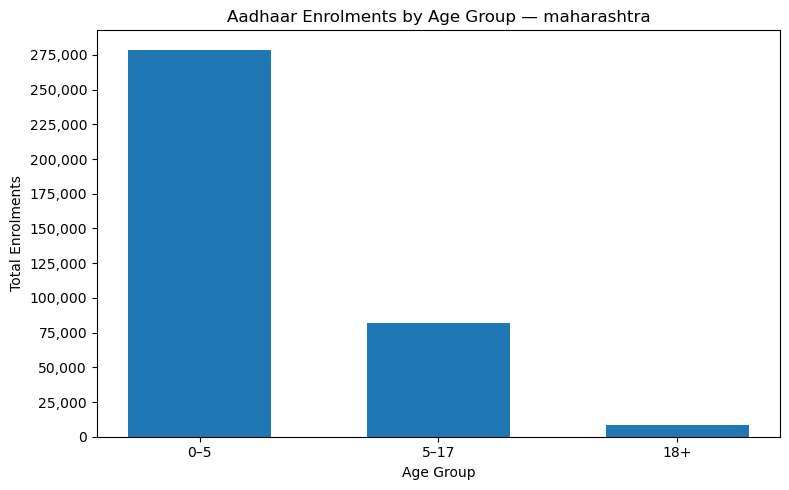

In [37]:
age_wise_analysis()

Enter State name (case-insensitive) [required]:  maharashtra
Enter District name (leave blank for state-level):  nagpur


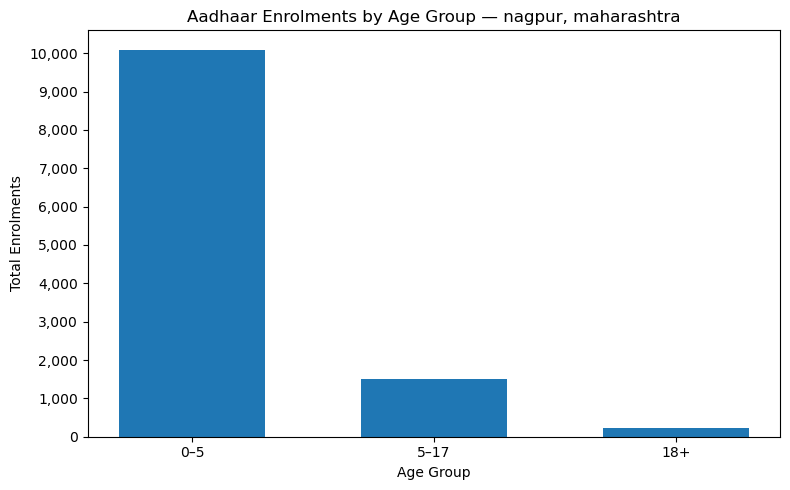

In [38]:
age_wise_analysis()

In [39]:
enrolment_trend_analysis()

Enter District name OR Pincode:  nagpur
Enter State (required for district analysis):  maharashtra


In [40]:
enrolment_trend_analysis()

Enter District name OR Pincode:  
Enter State (required for district analysis):  


No data found for this state/district.


Enter District name OR Pincode:  nagpur
Enter State (required for district analysis):  maharashtra


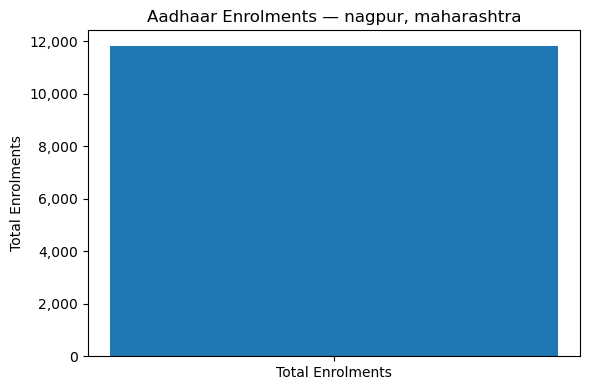

In [45]:
enrolment_trend_analysis()

Choose level (national/state/district/pincode):  district
Enter State (required):  maharashtra
Enter District:  nagpur


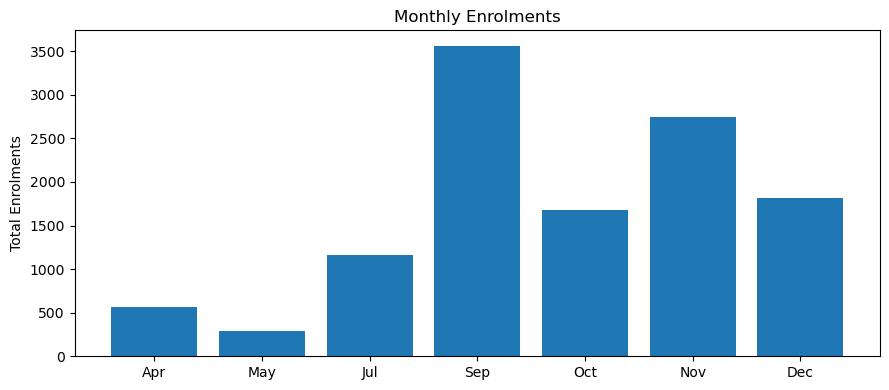

In [42]:
monthly_analysis()

Choose level (national/state/district/pincode):  district
Enter State (required):  maharashtra
Enter District:  nagpur


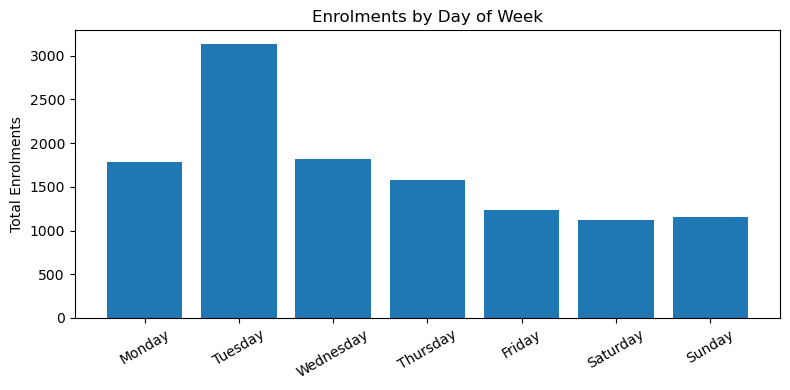

In [52]:
daywise_analysis()

Enter month number (1–12):  4
Choose level (national/state/district/pincode):  district
Enter State (required):  maharashtra
Enter District:  nagpur


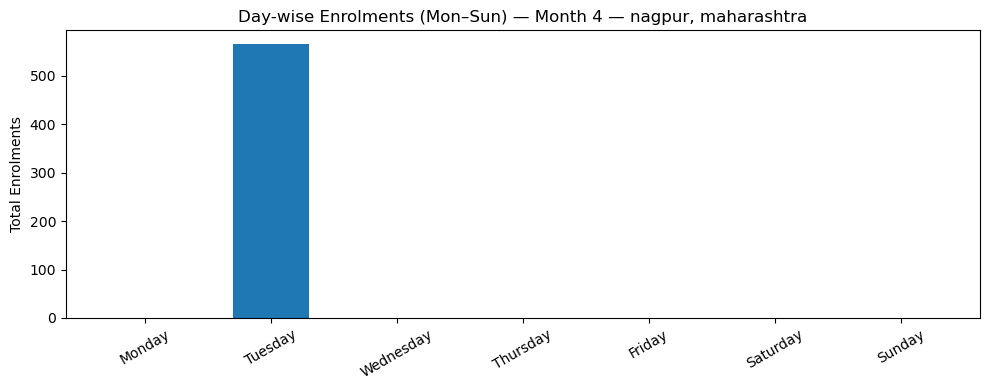

In [51]:
month_daywise_analysis()